In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [7]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [8]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [11]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
ds_info.features["label"].num_classes

10

In [18]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

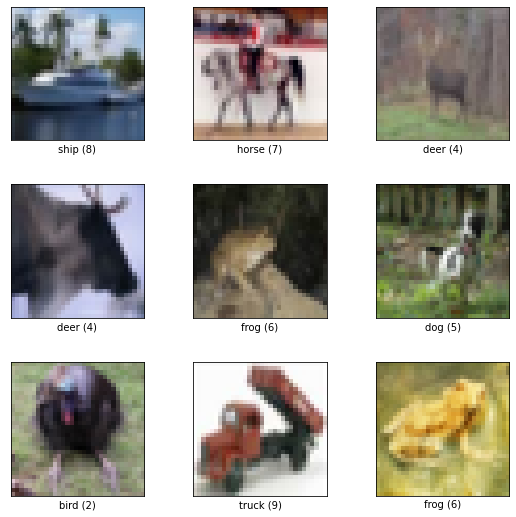

In [17]:
fig = tfds.show_examples(ds_train, ds_info)

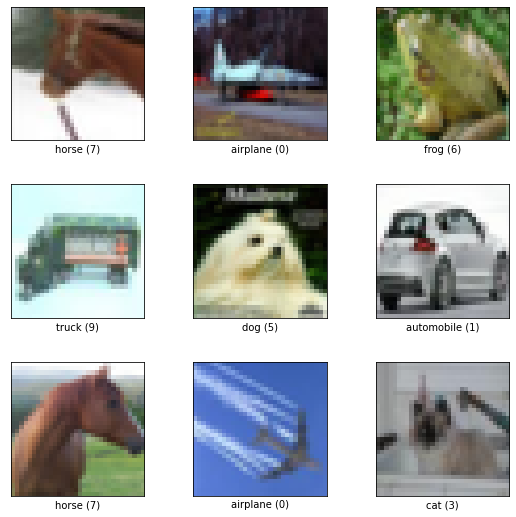

In [29]:
fig = tfds.show_examples(ds_test, ds_info)

ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG(16,19)를 예시로 구현해 보겠습니다.
블록을 구현하기 위해 모델 구조의 특징을 짚어보겠습니다.

* VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다.
* CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다. 
* 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다.
* 블록에 따라서 CNN 레이어의 개수 또한 달라집니다. 
* 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다.  

따라서 우리의 블록은 CNN 레이어 여러 개와 Maxpooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

In [30]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [31]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [32]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보겠습니다.

* VGG-16(sixteen weighted layers)

In [36]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [37]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

* VGG-19

In [40]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [41]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
vgg_13 = build_vgg(
    num_cnn_list=[2,2,3,3],
    channel_list=[64,128,256,512]
)

vgg_13.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

우선 CIFAR-10 데이터셋을 불러옵시다.

In [ ]:
########################
BATCH_SIZE = 256
EPOCH = 15
########################

In [42]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [43]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 84s 263ms/step - loss: 2.1842 - accuracy: 0.1844 - val_loss: 2.0849 - val_accuracy: 0.2349
Epoch 2/15
195/195 [==============================] - 46s 237ms/step - loss: 2.0121 - accuracy: 0.2708 - val_loss: 1.9348 - val_accuracy: 0.2983
Epoch 3/15
195/195 [==============================] - 47s 242ms/step - loss: 1.8847 - accuracy: 0.3240 - val_loss: 1.8152 - val_accuracy: 0.3548
Epoch 4/15
195/195 [==============================] - 48s 244ms/step - loss: 1.7802 - accuracy: 0.3616 - val_loss: 1.7585 - val_accuracy: 0.3763
Epoch 5/15
195/195 [==============================] - 46s 238ms/step - loss: 1.6914 - accuracy: 0.3900 - val_loss: 1.6789 - val_accuracy: 0.4030
Epoch 6/15
195/195 [==============================] - 45s 234ms/step - loss: 1.6266 - accuracy: 0.4112 - val_loss: 1.5997 - val_accuracy: 0.4276
Epoch 7/15
195/195 [==============================] - 44s 225ms/step - loss: 1.5622 - accuracy: 0.4378 - val_loss: 1.5631 - val_ac

steps_per_epoch : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정
validation_steps : validation data가 있을 때, 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정

In [44]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 57s 264ms/step - loss: 2.2226 - accuracy: 0.1684 - val_loss: 2.1354 - val_accuracy: 0.2301
Epoch 2/15
195/195 [==============================] - 51s 260ms/step - loss: 2.0603 - accuracy: 0.2514 - val_loss: 1.9920 - val_accuracy: 0.2705
Epoch 3/15
195/195 [==============================] - 51s 262ms/step - loss: 1.9300 - accuracy: 0.3023 - val_loss: 1.8525 - val_accuracy: 0.3227
Epoch 4/15
195/195 [==============================] - 51s 261ms/step - loss: 1.8054 - accuracy: 0.3511 - val_loss: 1.7243 - val_accuracy: 0.3841
Epoch 5/15
195/195 [==============================] - 51s 263ms/step - loss: 1.7048 - accuracy: 0.3848 - val_loss: 1.7256 - val_accuracy: 0.4013
Epoch 6/15
195/195 [==============================] - 51s 263ms/step - loss: 1.6424 - accuracy: 0.4082 - val_loss: 1.6069 - val_accuracy: 0.4229
Epoch 7/15
195/195 [==============================] - 51s 261ms/step - loss: 1.5839 - accuracy: 0.4313 - val_loss: 1.5225 - val_ac

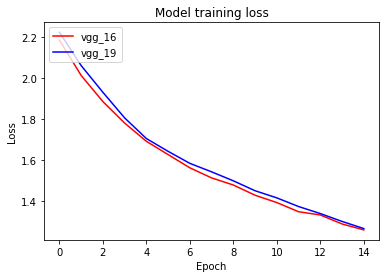

In [45]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
# plt.savefig('example.png', format='png')
plt.show()

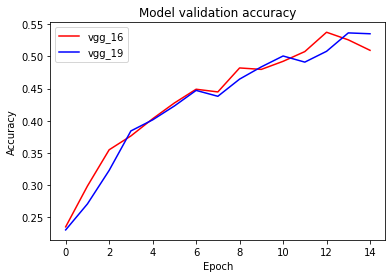

In [46]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
# plt.savefig('example.png', format='png')
plt.show()

In [47]:
# Save history to a file (using pickle)
import pickle

with open('history_16.pkl', 'wb') as f16:
    pickle.dump(history_16.history, f16)
 

In [48]:
# Load history from a file   
with open('history_16.pkl', 'rb') as f16:
    history_16_loaded = pickle.load(f16)

# Now you can use the history object
print(history_16_loaded.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [49]:
# Save history to a file (using pickle)
with open('history_19.pkl', 'wb') as f19:
    pickle.dump(history_19.history, f19)

In [50]:
# Load history from a file       
with open('history_19.pkl', 'rb') as f19:
    history_19_loaded = pickle.load(f19)

# Now you can use the history object
print(history_19_loaded.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


![reference](./reference.png)